# Sección nueva

# Context
Using a 10% sample (~100k users) of Uber's Rider to Eater data (encrypted), we leverage various meta-learners' predictions and validate the inference results through Sensitivity Analysis.


# Methodology
#### Data Prep
1. Calculate propensity (in this case, propensity of Riders converting into Eaters)
2. Match Treatment users with Control users using propensity score
3. Validate whether Control and Treatment have similar pre-treatment behavior by measuring Standardized Mean Difference (SMD) of matching covariates
4. Re-calibrate propensity scores again
5. Validate matching again using SMD

#### Modeling
1. Iterate over meta learners (S/T/X/R Learner) using 2 models (Linear Regression and XGBoost), and predict GB lift for every learner-model pair.
2. Compare predictions by examining ATE (Average Treatment Effect, which is simply the mean of predictions) and distribution of treatment effect.

#### Sensitivity Analysis
We provided five methods for sensitivity analysis including (Placebb Treatment, Random Cause, Subset Data, Random Replace and Selection Bias). 
This notebook will walkthrough how to use the combined function sensitivity_analysis() to compare different method and also how to use each individual method separately:

1. Placebo Treatment: Replacing treatment with a random variable
2. Irrelevant Additional Confounder: Adding a random common cause variable
3. Subset validation: Removing a random subset of the data
4. Selection Bias method with One Sided confounding function and Alignment confounding function
5. Random Replace: Random replace a covariate with an irrelevant variable

In [ ]:
!pip install causalml

     |████████████████████████████████| 406 kB 19.4 MB/s 
     |████████████████████████████████| 564 kB 26.6 MB/s 
     |████████████████████████████████| 1.8 MB 33.2 MB/s 
     |████████████████████████████████| 718 kB 42.1 MB/s 
     |████████████████████████████████| 750.6 MB 10 kB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1050916 sha256=bc8253bf643dc78aab086e897f631fc840b854337cbd0fe1c5a7db2f3ad1a9fd
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have t

In [ ]:
from platform import python_version

print(python_version())

3.7.13


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split
import warnings
import sys

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseRRegressor, BaseXRegressor
from causalml.match import NearestNeighborMatch, create_table_one, MatchOptimizer
from causalml.propensity import ElasticNetPropensityModel
from causalml.features import load_data
from causalml.features import LabelEncoder, OneHotEncoder
from causalml.metrics.sensitivity import Sensitivity

# from uberml.data.data import check_data
import seaborn as sns
from matplotlib import rcParams

plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 6,8
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
pd.options.display.max_seq_items = 2000
pd.options.display.float_format = '{:.4f}'.format

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Analysis Setup

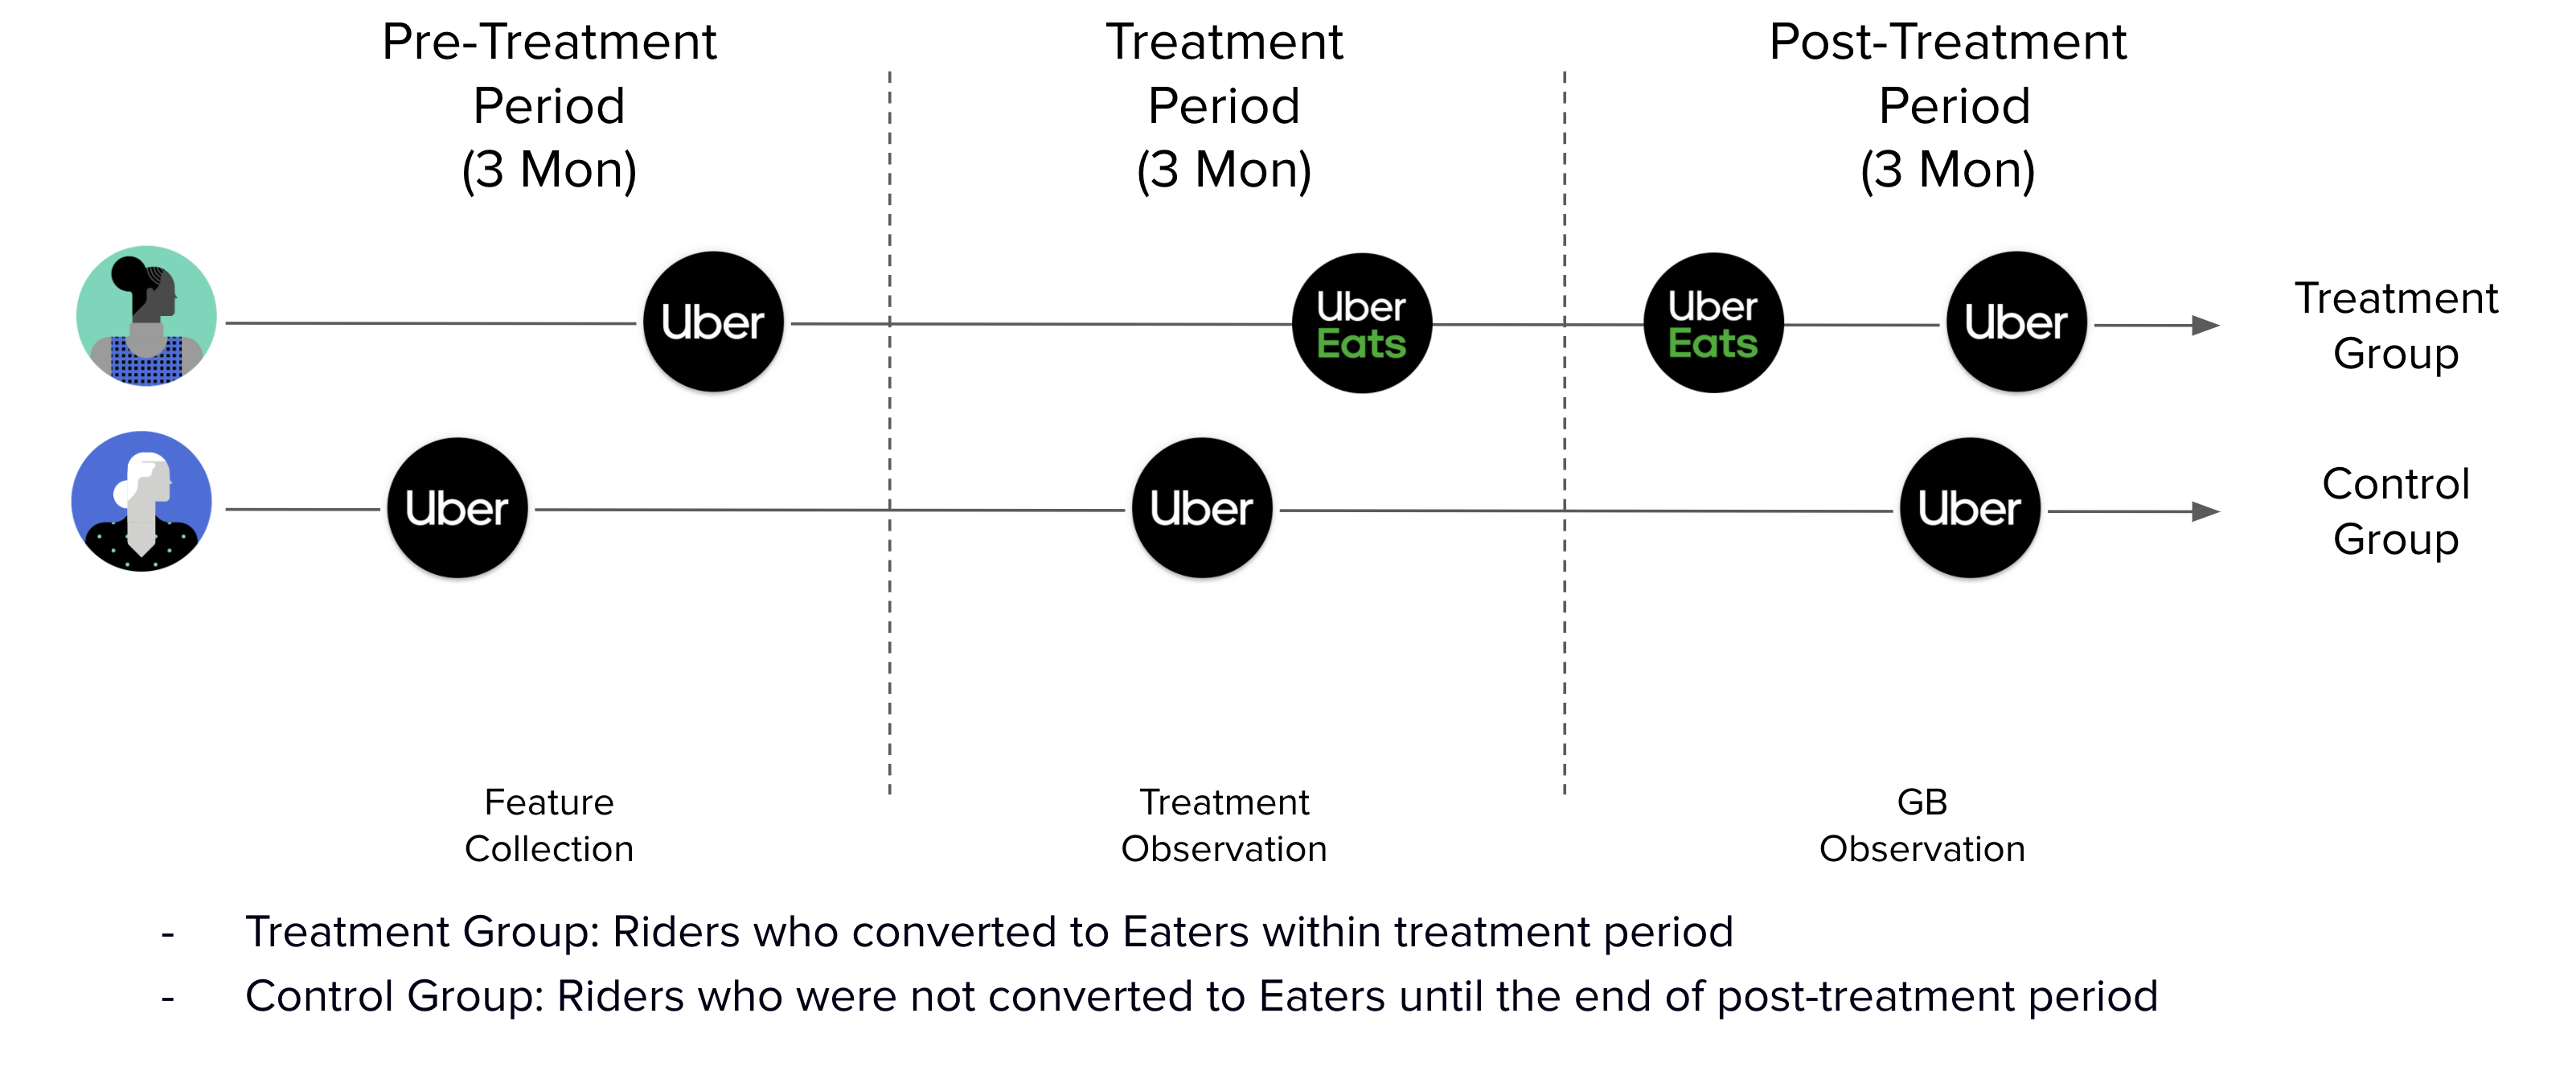

In [ ]:
def plot_evaluation(y_true, y_prob):
    """Plot evaluation metircs

    Args:
        y_true (pandas.Series): label
        y_pred (pandas.Series): prediciton results
        
    """  
    def plot_roc_curve(y, p):
        fpr, tpr, _ = roc_curve(y, p)     
        roc_auc = roc_auc_score(y, p)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='AUC = %0.1f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    def plot_pr_curve(y, p):
        precision, recall, _ = precision_recall_curve(y, p)

        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
    
    print('AUC: {:.1f}%'.format(roc_auc_score(y_true, y_prob) * 100))
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc_score = auc(recall, precision)
    print('PR AUC: {:.1f}%'.format(pr_auc_score * 100))
    
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot_roc_curve(y_true, y_prob)
    plt.subplot(1, 2, 2)
    plot_pr_curve(y_true, y_prob)

# Load data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KDD2021_CausalML/case_1_data_causalml.csv.gz')
print(df.shape)

FileNotFoundError: ignored

In [ ]:
df['target'].value_counts()

NameError: ignored

# Define Features

In [ ]:
OUTCOME_COL = 'y_col'
TREATMENT_COL = 'target'
SCORE_COL = 'pihat'
GROUPBY_COL = 'billing_zip'
NAN_INT = -98765    # A random integer to impute missing values with

In [ ]:
PROPENSITY_FEATURES = [
 'prob_features_0',
 'prob_features_1',
 'prob_features_2',
 'prob_features_3',
 'prob_features_4',
 'prob_features_5',
 'prob_features_6',
 'prob_features_7',
 'prob_features_8',
 'prob_features_9',
 'prob_features_10',
 'prob_features_11',
 'prob_features_12',
 'prob_features_13',
 'prob_features_14',
 'prob_features_15',
 'prob_features_16',
 'prob_features_17',
 'prob_features_18',
 'prob_features_19',
 'prob_features_20',
 'prob_features_21',
 'prob_features_22',
 'prob_features_23',
 'prob_features_24',
 'prob_features_25',
 'prob_features_26',
 'prob_features_27']

MATCHING_COVARIATES = [
 'prob_features_11',
 'prob_features_17',
 'prob_features_18',
 'prob_features_19',
 'prob_features_20',
 'prob_features_21',
 'prob_features_22',
 'prob_features_23',
 'prob_features_24'] + [SCORE_COL]

INFERENCE_FEATURES = PROPENSITY_FEATURES + [SCORE_COL]

# Data PreProcessing

## Categorical Features

In [ ]:
ENCODING_COLS = [
 'cat_features_0',
 'cat_features_1',
 'cat_features_2',
 'cat_features_3',
 'prob_features_15',
 'prob_features_16']

In [ ]:
# Label Encoding
threshold = int(0.001 * df.shape[0])
lbe = LabelEncoder(min_obs=threshold)
df[ENCODING_COLS] = lbe.fit_transform(df[ENCODING_COLS])

## Numerical Features

We pre-scaled the features already, so don't need to do any feature transfer here but we do recommd to check the distribution of the nuemerical features and do the transformation accordingly.

## Missing Values

In [ ]:
# Check if there any missing values
relevant_cols = np.union1d(PROPENSITY_FEATURES, np.union1d(MATCHING_COVARIATES, INFERENCE_FEATURES))
df[[c for c in relevant_cols if c in df]].isnull().sum()

prob_features_0     0
prob_features_1     0
prob_features_10    0
prob_features_11    0
prob_features_12    0
prob_features_13    0
prob_features_14    0
prob_features_15    0
prob_features_16    0
prob_features_17    0
prob_features_18    0
prob_features_19    0
prob_features_2     0
prob_features_20    0
prob_features_21    0
prob_features_22    0
prob_features_23    0
prob_features_24    0
prob_features_25    0
prob_features_26    0
prob_features_27    0
prob_features_3     0
prob_features_4     0
prob_features_5     0
prob_features_6     0
prob_features_7     0
prob_features_8     0
prob_features_9     0
dtype: int64

# Build Propensity Model

In [ ]:
params = {
          'objective': 'binary',
          'metric': 'auc',
          'learning_rate': 0.1,
          'num_leaves': 6,
          'bagging_freq': 1,
          'seed': 8,
          'verbose': 0,
          'num_threads': -1,
         }

PROPENSITY_FEATURES = [col for col in set(PROPENSITY_FEATURES + ENCODING_COLS) if col in df.columns]

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(df[PROPENSITY_FEATURES], df[TREATMENT_COL].values, test_size=0.2)

lgb_train = lgb.Dataset(X_trn, label=y_trn)
lgb_valid = lgb.Dataset(X_val, label=y_val)

clf = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                early_stopping_rounds=20,
                valid_sets=lgb_valid,
                verbose_eval=0)
n_best = clf.best_iteration
print('n_best', n_best)

n_best 114


In [ ]:
p_val = clf.predict(X_val)
print('Validation AUC={:.4f}'.format(roc_auc_score(y_val, p_val)))

Validation AUC=0.7205


In [ ]:
p_train = clf.predict(X_trn)
print('Train AUC={:.4f}'.format(roc_auc_score(y_trn, p_train)))

Train AUC=0.7520


In [ ]:
df['pihat']  = clf.predict(df[PROPENSITY_FEATURES])

In [ ]:
imp = pd.DataFrame({'feature': PROPENSITY_FEATURES, 
                    'gain': clf.feature_importance(importance_type='gain')})
imp.loc[:, 'gain'] = imp.gain / imp.gain.sum()
imp = imp.sort_values('gain', ascending=False).set_index('feature')
imp = imp.reset_index()
imp.head(n=10)

,feature,gain
0,cat_features_1,0.2616
1,prob_features_23,0.2308
2,prob_features_11,0.0791
3,prob_features_24,0.0564
4,prob_features_19,0.0507
5,cat_features_0,0.0305
6,prob_features_0,0.0286
7,prob_features_27,0.0253
8,prob_features_18,0.0241
9,prob_features_5,0.0197


AUC: 72.1%
PR AUC: 11.9%


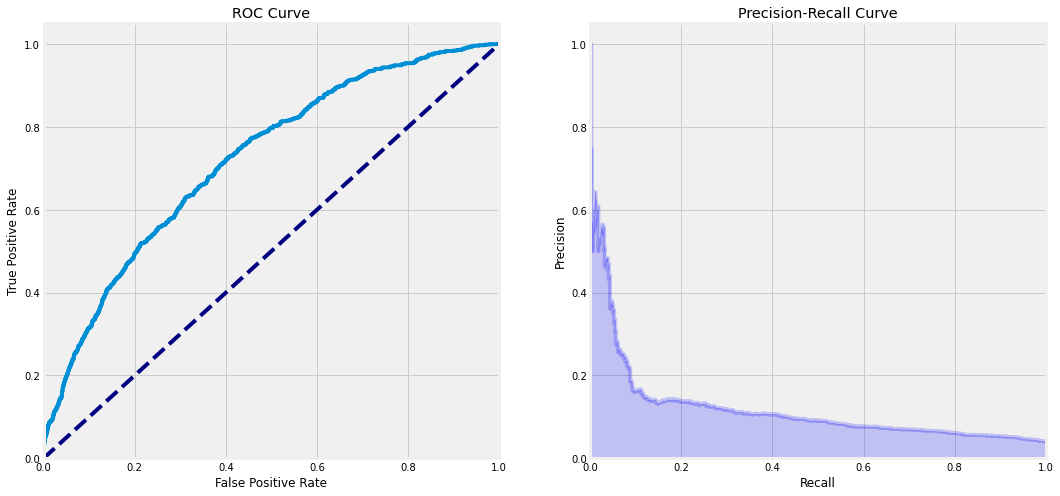

In [ ]:
plot_evaluation(y_val, p_val)

AUC: 75.2%
PR AUC: 17.8%


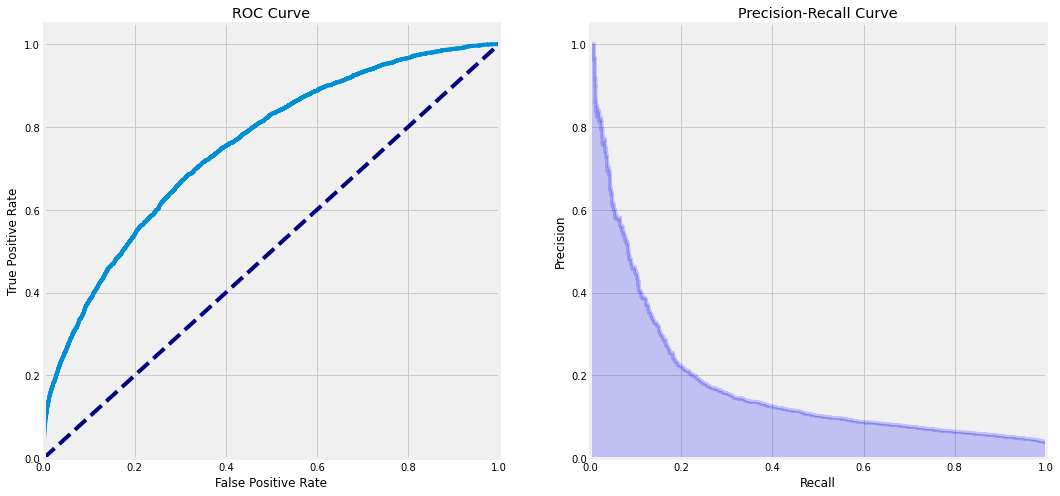

In [ ]:
plot_evaluation(y_trn, p_train)

# Propensity Score Matching

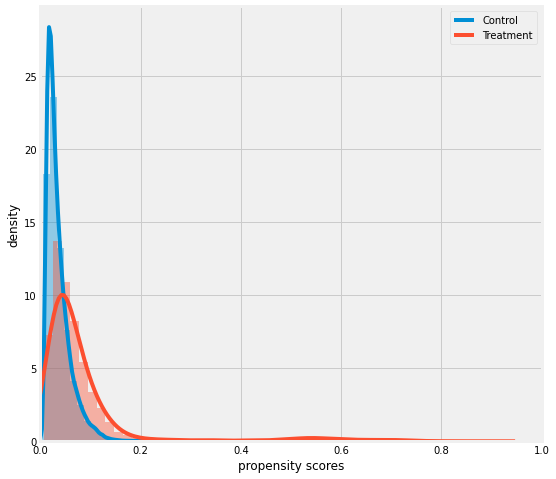

In [ ]:
# plot propensity score
rcParams['figure.figsize'] = 8,8
ax = sns.distplot(df[df[TREATMENT_COL] == 0]['pihat'])
sns.distplot(df[df[TREATMENT_COL] == 1]['pihat'])
ax.set_xlim(0, 1)
ax.set_xlabel("propensity scores")
ax.set_ylabel('density')
ax.legend(['Control', 'Treatment'])

In [ ]:
# before matching
create_table_one(df, treatment_col='target', features=MATCHING_COVARIATES)

,Control,Treatment,SMD
Variable,,,
n,96168,3832,
pihat,0.04 (0.03),0.09 (0.12),0.5841
prob_features_11,-0.01 (1.00),0.33 (1.06),0.3327
prob_features_17,-0.00 (1.01),0.02 (0.85),0.0230
prob_features_18,-0.00 (1.01),0.01 (0.84),0.0080
prob_features_19,0.01 (1.00),-0.33 (0.84),-0.3727
prob_features_20,-0.02 (0.98),0.39 (1.41),0.3374
prob_features_21,0.00 (0.99),-0.06 (1.15),-0.0601
prob_features_22,-0.00 (1.00),0.03 (0.87),0.0290


In [ ]:
matcher = NearestNeighborMatch(caliper=0.01, replace=True)
df_matched = matcher.match(data=df, treatment_col='target', score_cols=['pihat'])

In [ ]:
# after matching
create_table_one(df_matched, treatment_col='target', features=MATCHING_COVARIATES)

,Control,Treatment,SMD
Variable,,,
n,3656,3656,
pihat,0.07 (0.06),0.07 (0.06),0.0000
prob_features_11,0.39 (1.07),0.36 (1.06),-0.0295
prob_features_17,0.02 (0.81),0.02 (0.84),0.0021
prob_features_18,0.03 (0.82),0.01 (0.82),-0.0305
prob_features_19,-0.40 (0.79),-0.35 (0.82),0.0674
prob_features_20,0.56 (1.58),0.41 (1.40),-0.1040
prob_features_21,-0.07 (1.26),-0.05 (1.05),0.0162
prob_features_22,0.05 (0.94),0.03 (0.86),-0.0251


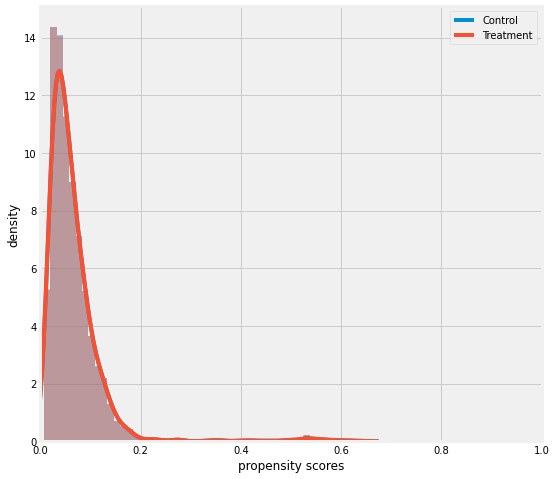

In [ ]:
# plot propensity score
ax = sns.distplot(df_matched[df_matched[TREATMENT_COL] == 0]['pihat'])
sns.distplot((df_matched[df_matched[TREATMENT_COL] == 1]['pihat']))
ax.set_xlim(0, 1)
ax.set_xlabel("propensity scores")
ax.set_ylabel('density')
ax.legend(['Control', 'Treatment'])



```
# This is formatted as code
```

### Re-Calibrate propensity (`pihat_recal`) after matching

In [ ]:
p_model = ElasticNetPropensityModel()
ohe = OneHotEncoder(min_obs=df.shape[0] * 0.01)
X_cat = ohe.fit_transform(df_matched[ENCODING_COLS]).todense()
X = np.hstack([df_matched[PROPENSITY_FEATURES].values, X_cat])

df_matched['pihat_recal'] = p_model.fit_predict(X, df_matched['target'])

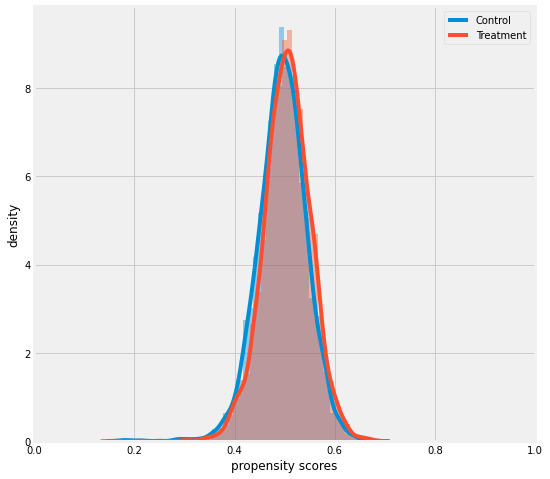

In [ ]:
# plot propensity score
ax = sns.distplot(df_matched[df_matched[TREATMENT_COL] == 0]['pihat_recal'])
sns.distplot((df_matched[df_matched[TREATMENT_COL] == 1]['pihat_recal']))
ax.set_xlim(0, 1)
ax.set_xlabel("propensity scores")
ax.set_ylabel('density')
ax.legend(['Control', 'Treatment'])

# Inference Analysis

In [ ]:
def prepare_inputs(df, p_col='pihat', w_col='target', y_col='post_sum_gross_bookings', inference_features=INFERENCE_FEATURES):
    X =df[INFERENCE_FEATURES].values
    p = df[p_col].values
    w = df[w_col].values
    df[y_col] = df[y_col].fillna(0)
    y = df[y_col].values

    return X, p ,w, y

In [ ]:
INFERENCE_FEATURES_LR =[col for col in INFERENCE_FEATURES if col not in ENCODING_COLS ]

In [ ]:
def run_learners(df, p_col='pihat', w_col='target', y_col='post_sum_gross_bookings', k=5):
    preds_dict = {}
    
    for base_learner,label_l in zip([BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor],['S', 'T','X','R']):
        for model,label_m in zip([LinearRegression, XGBRegressor],['LR', 'XGB']):
            if label_m !='LR':
                X, p, w, y = prepare_inputs(df, p_col, w_col, y_col)
            else:
                ohe = OneHotEncoder(min_obs=df.shape[0] * 0.01)
                X_cat = ohe.fit_transform(df[ENCODING_COLS]).todense()
                X = np.hstack([df[INFERENCE_FEATURES_LR].values, X_cat])
                p = df[p_col].values
                w = df[w_col].values
                df[y_col] = df[y_col].fillna(0)
                y = df[y_col].values                
                
            if label_l == 'S':
                learner = base_learner(learner=model())
                ate, lb, ub = learner.estimate_ate(X=X,treatment=w,y=y,return_ci=True)  
                preds_dict['{} Learner ({})'.format(label_l, label_m)] = np.ravel([ate, lb, ub])
            elif label_l == 'T':
                learner = base_learner(learner=model())
                ate, lb, ub = learner.estimate_ate(X=X,treatment=w,y=y)  
                preds_dict['{} Learner ({})'.format(label_l, label_m)] = np.ravel([ate, lb, ub])
            elif label_l == 'X':
                learner = base_learner(learner=model())
                ate, lb, ub = learner.estimate_ate(X=X,p=p,treatment=w,y=y)  
                preds_dict['{} Learner ({})'.format(label_l, label_m)] = np.ravel([ate, lb, ub])
            elif label_l == 'R':
                learner = base_learner(model(), n_fold=k)
                ate, lb, ub = learner.estimate_ate(X=X,p=p,treatment=w,y=y) 
                preds_dict['{} Learner ({})'.format(label_l, label_m)] = np.ravel([ate, lb, ub])     
    return preds_dict

In [ ]:
def get_ate_summary(df, preds_dict, w_col='target', y_col='y_col'):
    preds_df = pd.DataFrame(preds_dict).T
    preds_df.columns = ['ATE', 'Lower', 'Upper']
    post_treatment = df[df[w_col]==1][y_col].mean()
    preds_df['Baseline'] = post_treatment - preds_df['ATE']
    preds_df['Lift'] = preds_df['ATE'] / preds_df['Baseline']
    preds_df = preds_df.round(4)
    return preds_df.T

In [ ]:
# After Re-Calibrate
preds = run_learners(df_matched, y_col='y_col', p_col='pihat_recal')
get_ate_summary(df_matched, preds, y_col='y_col')

[03:00:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:00:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:00:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:00:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:00:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:00:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:00:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:00:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,S Learner (LR),S Learner (XGB),T Learner (LR),T Learner (XGB),X Learner (LR),X Learner (XGB),R Learner (LR),R Learner (XGB)
ATE,0.4473,0.3964,0.4479,0.4405,0.4479,0.4437,0.4458,0.4450
Lower,0.3923,0.3478,0.3928,0.3933,0.3928,0.3975,0.4451,0.4444
Upper,0.5024,0.4450,0.5030,0.4876,0.5030,0.4899,0.4465,0.4457
Baseline,0.2896,0.3405,0.2891,0.2964,0.2891,0.2932,0.2911,0.2919
Lift,1.5446,1.1641,1.5495,1.4859,1.5495,1.5131,1.5313,1.5246


# Sensitivity Analysis

All Five methods (with One Sided confounding function and default alpha)

In [ ]:
# Calling the Base XLearner class and return the sensitivity analysis summary report
learner_x = BaseXRegressor(LinearRegression())
sens_x = Sensitivity(df=df_matched, inference_features=INFERENCE_FEATURES, p_col='pihat_recal',
                     treatment_col=TREATMENT_COL, outcome_col=OUTCOME_COL, learner=learner_x)
# Here for Selection Bias method will use default one-sided confounding function and alpha (quantile range of outcome values) input
sens_sumary_x = sens_x.sensitivity_analysis(methods=['Placebo Treatment',
                                                     'Random Cause',
                                                     'Subset Data',
                                                     'Random Replace',
                                                     'Selection Bias'], sample_size=0.9)

In [ ]:
# From the following results, refutation methods show our model is pretty robust; 
# When alpah > 0, the treated group always has higher mean potential outcomes than the control; when  < 0, the control group is better off.
sens_sumary_x

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,0.4552,0.0174,-0.0387,0.0736
0,Random Cause,0.4552,0.4546,0.3994,0.5098
0,Subset Data(sample size @0.9),0.4552,0.4477,0.3901,0.5054
0,Random Replace,0.4552,0.4549,0.3997,0.5101
0,"Selection Bias (alpha@-0.6281, with r-sqaure:0...",0.4552,1.0816,1.0264,1.1368
0,"Selection Bias (alpha@-0.50248, with r-sqaure:...",0.4552,0.9563,0.9011,1.0115
0,"Selection Bias (alpha@-0.37686, with r-sqaure:...",0.4552,0.8310,0.7758,0.8862
0,"Selection Bias (alpha@-0.25124, with r-sqaure:...",0.4552,0.7058,0.6506,0.7610
0,"Selection Bias (alpha@-0.12562, with r-sqaure:...",0.4552,0.5805,0.5253,0.6357
0,"Selection Bias (alpha@0.0, with r-sqaure:0.0",0.4552,0.4552,0.4000,0.5104
